In [1]:
from keras.layers import Input, Dense, Activation, Dropout, LeakyReLU, Lambda, PReLU
from keras.models import Model, Sequential, model_from_json
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras import optimizers, activations, regularizers, losses
from keras import backend as K
from keras.backend import sigmoid
from sklearn.model_selection import train_test_split, KFold
from keras.utils.generic_utils import get_custom_objects
import matplotlib as mpl
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import h5py
import json

Using TensorFlow backend.


## ROM Data Processing and Splitting

In [2]:
'''Import data'''

# File path
data = h5py.File('/Users/maggiezhang/Dropbox/AtmosphereMachineLearning/DensityData/JB2008_1999_2010_ROM_r100.mat', 'r')
print(data.keys())
# Reduced-order density data
dens_data = data.get('densityDataLogVarROM100')
dens_data = np.array(dens_data)
u = np.array(data.get("U100")).T
densityDataMeanLog = np.array(data.get("densityDataMeanLog")).T
print(densityDataMeanLog.shape)

# Space weather data
sw_data = data.get('SWdataFull')
sw_data = np.array(sw_data)
sw_data = sw_data.transpose()

#number of future hours to predict
pred_number = 48

# Only consider first 10 modes/dimensions of reduced data
dens_data = dens_data[:,0:10]

'''Training data'''
# Testing the 70, 15, 15 for train, val, test 

split_15 = int(dens_data.shape[0]*0.85) # manual test split 

dens_data_train = dens_data[0:split_15-pred_number,:]
sw_data_train = sw_data[0:split_15-pred_number,:]
sw_data_train_append = sw_data[1:split_15-pred_number+1,:] #looks at next sw timestep because it could be useful in prediction 
sw_data_train = np.concatenate((sw_data_train, sw_data_train_append), axis=1)
# Input is reduced-order density and space weather data
x_train = np.concatenate((dens_data_train, sw_data_train), axis=1)

# Training output
# Output is reduced-order density data at next time step
y_train = dens_data[1:split_15-pred_number+1,:]
print(x_train.shape)
'''ROM LINEAR MATRICES''' 
Om = x_train.T#np.append(np.transpose(dens_data_train), np.transpose(sw_data_train), axis = 0)
print(Om.shape)
X2 = np.transpose(y_train)

# Compute dynamic matrices:
# Phi = X2*pinv(Om)
Phi = np.matmul(X2,np.linalg.pinv(Om))

r = 10 #reduced order 
A = Phi[:r, :r]
B = Phi[:r, r:]

'''Test data'''
# Test input
dens_data_test = dens_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test = sw_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test_append = sw_data[split_15-pred_number:-pred_number-1,:]
sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
# Input is reduced-order density and space weather data
x_test = np.concatenate((dens_data_test, sw_data_test), axis=1)
# Test output
# Output is reduced-order density data at next time step
y_test = dens_data[split_15-pred_number:-pred_number-1,:]
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647) #, random_state=42)

<KeysViewHDF5 ['D100', 'SWdataFull', 'U100', 'altitudes', 'densityDataLogVarROM100', 'densityDataMeanLog', 'latitudes', 'localSolarTimes']>
(17280, 1)
(87845, 38)
(38, 87845)


In [3]:
with open('JB_POD.json','r') as f:
    model_NN_json = json.load(f)
    model_NN_json = json.dumps(model_NN_json)
    model_NN_json = str(model_NN_json)

model_NN = model_from_json(model_NN_json)
model_NN.load_weights('JB_POD.h5')
model_NN.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 120)               4680      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 120)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 40)                4840      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 40)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 20)                820       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 20)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)               

## Original Model with 3 Leaky layers of 0.3

In [84]:
'''Create NN'''
def swish(x, beta=1.0):
    return x * K.sigmoid(beta * x)

def leaky_relu6(x):
    return K.relu(x, alpha = 0.3)

model = Sequential()
model.add(Dense(120, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(40, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(20, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(10, kernel_initializer='random_uniform'))


Train on 73614 samples, validate on 15775 samples
Epoch 1/500
73614/73614 [==============================] - 2s 31us/step - loss: 17.3782 - accuracy: 0.8850 - val_loss: 1.0231 - val_accuracy: 0.9389
Epoch 2/500
73614/73614 [==============================] - 3s 40us/step - loss: 0.7232 - accuracy: 0.9469 - val_loss: 0.2401 - val_accuracy: 0.9746
Epoch 3/500
73614/73614 [==============================] - 2s 28us/step - loss: 0.1984 - accuracy: 0.9748 - val_loss: 0.1780 - val_accuracy: 0.9764
Epoch 4/500
73614/73614 [==============================] - 2s 29us/step - loss: 0.1506 - accuracy: 0.9775 - val_loss: 0.1217 - val_accuracy: 0.9805
Epoch 5/500
73614/73614 [==============================] - 2s 28us/step - loss: 0.1209 - accuracy: 0.9807 - val_loss: 0.1125 - val_accuracy: 0.9811
Epoch 6/500
73614/73614 [==============================] - 2s 28us/step - loss: 0.1027 - accuracy: 0.9824 - val_loss: 0.0949 - val_accuracy: 0.9834
Epoch 7/500
73614/73614 [==============================] - 2s

Epoch 56/500
73614/73614 [==============================] - 2s 33us/step - loss: 0.0179 - accuracy: 0.9941 - val_loss: 0.0137 - val_accuracy: 0.9953
Epoch 57/500
73614/73614 [==============================] - 2s 33us/step - loss: 0.0176 - accuracy: 0.9939 - val_loss: 0.0136 - val_accuracy: 0.9959
Epoch 58/500
73614/73614 [==============================] - 2s 33us/step - loss: 0.0171 - accuracy: 0.9943 - val_loss: 0.0217 - val_accuracy: 0.9953
Epoch 59/500
73614/73614 [==============================] - 2s 33us/step - loss: 0.0177 - accuracy: 0.9943 - val_loss: 0.0196 - val_accuracy: 0.9947
Epoch 60/500
73614/73614 [==============================] - 3s 35us/step - loss: 0.0167 - accuracy: 0.9945 - val_loss: 0.0110 - val_accuracy: 0.9954
Epoch 61/500
73614/73614 [==============================] - 2s 33us/step - loss: 0.0167 - accuracy: 0.9942 - val_loss: 0.0140 - val_accuracy: 0.9958
Epoch 62/500
73614/73614 [==============================] - 3s 35us/step - loss: 0.0162 - accuracy: 0.9946

Epoch 111/500
73614/73614 [==============================] - 3s 35us/step - loss: 0.0110 - accuracy: 0.9957 - val_loss: 0.0090 - val_accuracy: 0.9966
Epoch 112/500
73614/73614 [==============================] - 2s 34us/step - loss: 0.0115 - accuracy: 0.9953 - val_loss: 0.0072 - val_accuracy: 0.9965
Epoch 113/500
73614/73614 [==============================] - 3s 35us/step - loss: 0.0111 - accuracy: 0.9953 - val_loss: 0.0083 - val_accuracy: 0.9964
Epoch 114/500
73614/73614 [==============================] - 3s 36us/step - loss: 0.0115 - accuracy: 0.9952 - val_loss: 0.0108 - val_accuracy: 0.9963
Epoch 115/500
73614/73614 [==============================] - 3s 35us/step - loss: 0.0113 - accuracy: 0.9953 - val_loss: 0.0073 - val_accuracy: 0.9974
Epoch 116/500
73614/73614 [==============================] - 3s 35us/step - loss: 0.0110 - accuracy: 0.9956 - val_loss: 0.0228 - val_accuracy: 0.9926
Epoch 117/500
73614/73614 [==============================] - 3s 35us/step - loss: 0.0113 - accuracy:

Epoch 220/500
73614/73614 [==============================] - 3s 36us/step - loss: 0.0072 - accuracy: 0.9963 - val_loss: 0.0152 - val_accuracy: 0.9919
Epoch 221/500
73614/73614 [==============================] - 3s 43us/step - loss: 0.0072 - accuracy: 0.9960 - val_loss: 0.0069 - val_accuracy: 0.9964
Epoch 222/500
73614/73614 [==============================] - 3s 41us/step - loss: 0.0072 - accuracy: 0.9966 - val_loss: 0.0049 - val_accuracy: 0.9961
Epoch 223/500
73614/73614 [==============================] - 3s 41us/step - loss: 0.0071 - accuracy: 0.9964 - val_loss: 0.0103 - val_accuracy: 0.9960
Epoch 224/500
73614/73614 [==============================] - 3s 39us/step - loss: 0.0075 - accuracy: 0.9965 - val_loss: 0.0048 - val_accuracy: 0.9971
Epoch 225/500
73614/73614 [==============================] - 3s 39us/step - loss: 0.0067 - accuracy: 0.9970 - val_loss: 0.0104 - val_accuracy: 0.9952
Epoch 226/500
73614/73614 [==============================] - 3s 39us/step - loss: 0.0074 - accuracy:

Epoch 329/500
73614/73614 [==============================] - 3s 44us/step - loss: 0.0052 - accuracy: 0.9971 - val_loss: 0.0044 - val_accuracy: 0.9966
Epoch 330/500
73614/73614 [==============================] - 3s 45us/step - loss: 0.0054 - accuracy: 0.9969 - val_loss: 0.0049 - val_accuracy: 0.9970
Epoch 331/500
73614/73614 [==============================] - 3s 45us/step - loss: 0.0057 - accuracy: 0.9970 - val_loss: 0.0060 - val_accuracy: 0.9970
Epoch 332/500
73614/73614 [==============================] - 3s 44us/step - loss: 0.0058 - accuracy: 0.9968 - val_loss: 0.0044 - val_accuracy: 0.9975
Epoch 333/500
73614/73614 [==============================] - 3s 43us/step - loss: 0.0055 - accuracy: 0.9972 - val_loss: 0.0046 - val_accuracy: 0.9977
Epoch 334/500
73614/73614 [==============================] - 3s 45us/step - loss: 0.0056 - accuracy: 0.9969 - val_loss: 0.0078 - val_accuracy: 0.9959
Epoch 335/500
73614/73614 [==============================] - 3s 44us/step - loss: 0.0054 - accuracy:

Epoch 438/500
73614/73614 [==============================] - 4s 50us/step - loss: 0.0046 - accuracy: 0.9972 - val_loss: 0.0027 - val_accuracy: 0.9980
Epoch 439/500
73614/73614 [==============================] - 4s 48us/step - loss: 0.0046 - accuracy: 0.9974 - val_loss: 0.0041 - val_accuracy: 0.9980
Epoch 440/500
73614/73614 [==============================] - 4s 48us/step - loss: 0.0046 - accuracy: 0.9971 - val_loss: 0.0106 - val_accuracy: 0.9958
Epoch 441/500
73614/73614 [==============================] - 4s 49us/step - loss: 0.0048 - accuracy: 0.9972 - val_loss: 0.0093 - val_accuracy: 0.9966
Epoch 442/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0046 - accuracy: 0.9971 - val_loss: 0.0042 - val_accuracy: 0.9974
Epoch 443/500
73614/73614 [==============================] - 3s 46us/step - loss: 0.0047 - accuracy: 0.9972 - val_loss: 0.0085 - val_accuracy: 0.9953
Epoch 444/500
73614/73614 [==============================] - 4s 48us/step - loss: 0.0045 - accuracy:

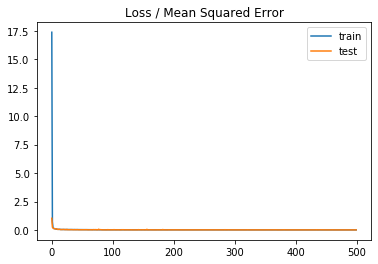

In [85]:
'''Train NN'''
ad = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=ad, loss='mse', metrics=['accuracy'])
history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 1000, batch_size = 32)
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()


## Plot Errors and Save Model to JSON/h5 file

'\nmodel_json = model.to_json()\nwith open("NN_model_NRLMSISE.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel.save_weights("NN_model_NRLMSISE.h5")\nprint("Saved model")\n#'

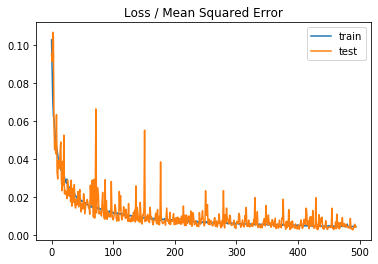

In [87]:
model_json = model.to_json()
with open("JB_POD.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("JB_POD.h5")
print("Saved model")

## Compare errors over recurrent timesteps for test_model
>for pred_number of hrs

(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
(15510, 10)
[[0.00101308 0.00252362 0.00424682 0.00627278 0.00866643 0.01143518
  0.01456795 0.01805067 0.02185965 0.02597026 0.03035544 0.03498861
  0.03984913 0.04491357 0.05015815 0.05557135 0.06114097 0.06685896
  0.07272339 0.07872951 0.08487754 0.09117572 0.09762478 0.10422382
  0.11098478 0.11789293 0.12495088 0.13216101 0.13951999 0.1470295
  0.15468627 0.16248445 0.17042087 0.17848828 0.18667799 0.19498682
  0.20341418 0.21

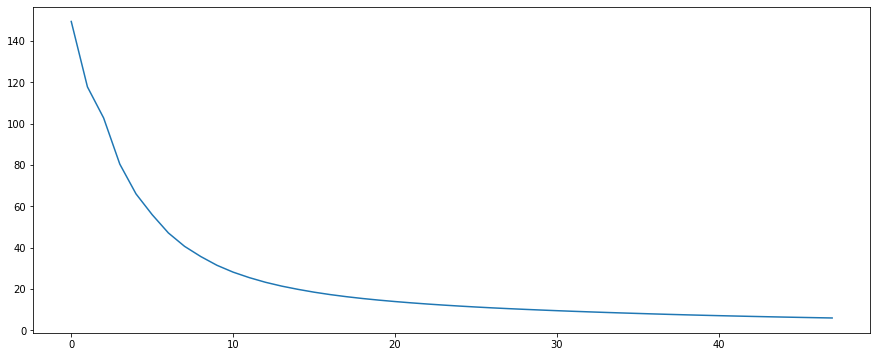

In [4]:
mse_NN = np.zeros((1,pred_number))
mse_ROM = np.zeros((1,pred_number))

x_test_rom = np.copy(x_test)
x_test_NN = np.copy(x_test)
y_test_NN = np.copy(y_test)

prediction_NN = np.empty((15778,10))
prediction_POD = np.empty((15778,10))
NN_prediction = None
DMDc_prediction = None

for b in range(pred_number):
    y_pred = model_NN.predict(x_test_NN)
    print(y_pred.shape)
    if not b: NN_prediction = np.reshape(y_pred[-1,:],(1,10))
    else: NN_prediction = np.append(NN_prediction, np.reshape(y_pred[-1,:],(1,10)),axis = 0)
    y_test_NN = dens_data[split_15-pred_number+b:-pred_number-1+b,:]
    mse_NN[0][b] = np.sum(np.square(y_test_NN-y_pred))/(y_pred.shape[1]*y_pred.shape[0])
    mse2 = np.sum(np.square(y_pred-y_test_NN),axis = 1)
    sw_data_test = sw_data[split_15-pred_number+b:-pred_number-1+b,:]
    sw_data_test_append = sw_data[split_15-pred_number+1+b:-pred_number+b,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)

print(mse_NN) 

for a in range(pred_number):
    y_test = dens_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = sw_data[split_15-pred_number-1+a:-pred_number-2+a,:]
    sw_data_test_append = sw_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    if (a!= 0):
        x_test_rom = np.concatenate((x_test_rom, sw_data_test), axis=1)
    sw_data_test_ROM = x_test_rom[:,10:]
    dens_data_test_ROM = x_test_rom[:,:10]
    #print(dens_data_test_ROM.shape)
    XfullPred = np.transpose(np.matmul(A,np.transpose(dens_data_test_ROM)) + np.matmul(B,np.transpose(sw_data_test_ROM)))
    print(XfullPred.shape)
    if not a: DMDc_prediction = np.reshape(XfullPred[-1,:],(1,10))
    else: DMDc_prediction = np.append(DMDc_prediction, np.reshape(XfullPred[-1,:],(1,10)),axis = 0)
    prediction_POD = np.append(prediction_POD, XfullPred, axis =0)
    x_test_rom = np.copy(XfullPred)
    errFullPred = abs(XfullPred-y_test)
    mse_ROM[0][a] = np.sum(np.square(errFullPred))/(errFullPred.shape[1]*errFullPred.shape[0])
    mse_rom2 = np.sum(np.square(errFullPred),axis = 1)
    
print(mse_ROM) 

factor = np.divide(np.transpose(mse_ROM), np.transpose(mse_NN))
plt.figure(figsize = (15,6))
plt.plot(factor)

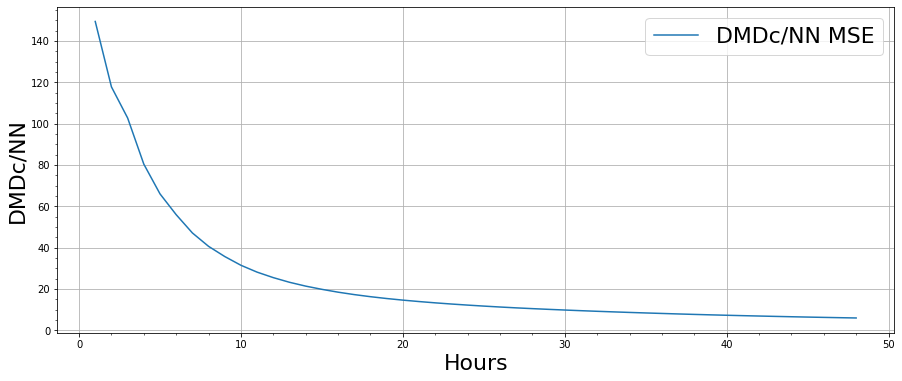

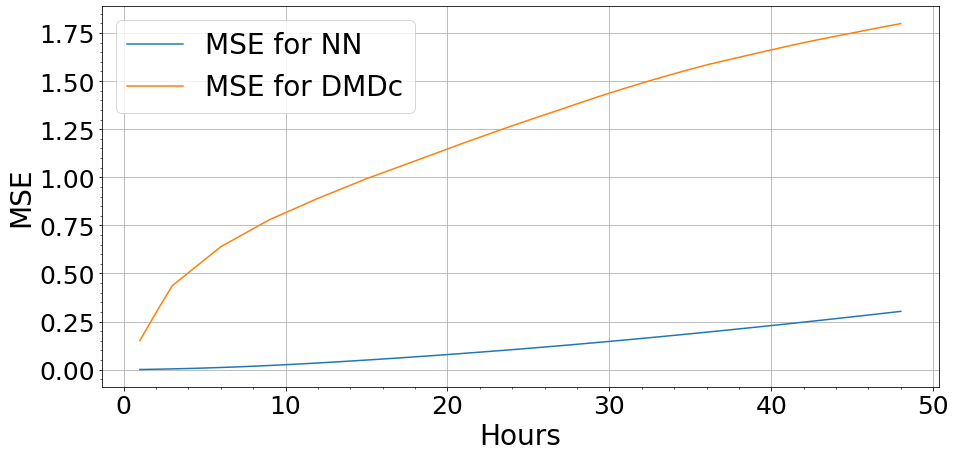

In [8]:
plt.figure(figsize = (15,6))
#plt.title("JB 1999-2010: DMDc/NN MSE for 24 Hours Time Series using POD")
plt.plot(range(1,1+len(factor)),factor, label = "DMDc/NN MSE")
plt.grid()
plt.minorticks_on()
plt.legend(fontsize=22)
plt.xlabel("Hours", fontsize=22)
plt.ylabel("DMDc/NN", fontsize=22)
#plt.savefig('POD_JB_DMDc/NN_Ratio.png')  
#plt.show()


plt.figure(figsize = (15,7))
#plt.title("JB 1999-2010: Comparison of MSE for 24 Hours Time Series using POD")
plt.plot(range(1,1+len(factor)),mse_NN.T, label = "MSE for NN")
plt.plot(range(1,1+len(factor)),mse_ROM.T, label = "MSE for DMDc")
plt.grid()
plt.minorticks_on()
plt.xlabel("Hours",fontsize=28)
plt.ylabel("MSE",fontsize=28)
plt.legend(fontsize=28)
plt.xticks(size = 25)
plt.yticks(size = 25)
plt.savefig('POD_JB_DMDc_NN_MSE_48.png')
#plt.show()

In [34]:
x_test_NN = x_test[0,:]
x_test_NN= np.reshape(x_test_NN, (1, 38))
x_test_rom = np.reshape(x_test[0,:10], (1, 10))

NN_prediction = None
for b in range(pred_number):
    y_pred = model_NN.predict(x_test_NN)
    if b == 0:
        NN_prediction = y_pred
    else:
        NN_prediction = np.append(NN_prediction, y_pred, axis = 0)
    sw_data_test = np.reshape(sw_data[b,:], (1,14))
    sw_data_test_append = np.reshape(sw_data[b+1,:],(1,14))
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)
    
DMDc_prediction = None
for a in range(pred_number):
    #General
    sw_data_test = np.reshape(sw_data[a,:], (1,14))
    sw_data_test_append = np.reshape(sw_data[a+1,:], (1,14))
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_rom = np.transpose(np.matmul(A,np.transpose(x_test_rom)) + np.matmul(B,np.transpose(sw_data_test)))
    if not a:
        DMDc_prediction = x_test_rom
    else:
        DMDc_prediction = np.append(DMDc_prediction, x_test_rom, axis = 0)

In [35]:
print(y_test.shape)
print(x_test.shape)
actual = y_test[:pred_number,:]
print(actual.shape)
NN_error = (NN_prediction-actual)
DMDc_error = (DMDc_prediction-actual)
print(np.sum(np.square(NN_error))/(NN_error.shape[0]*NN_error.shape[1]))
print(np.sum(np.square(DMDc_error))/(DMDc_error.shape[0]*DMDc_error.shape[1]))
print(NN_error.shape)
print(DMDc_error.shape)

(15510, 10)
(15510, 38)
(48, 10)
86.99984247757337
26.95895478460657
(48, 10)
(48, 10)


In [36]:
nndecoded = np.matmul(u[:,:r], NN_prediction.T)
DMDcdecoded = np.matmul(u[:,:r], DMDc_prediction.T)
actualdecoded = np.matmul(u[:,:r], actual.T)
NN_error_decoded = np.matmul(u[:,:r], NN_error.T)
DMDc_error_decoded = np.matmul(u[:,:r], DMDc_error.T)

In [37]:
matrixof10 = np.full((17280, pred_number), 10)
print((nndecoded+densityDataMeanLog).shape)
densityNNPred = np.power(matrixof10,(nndecoded+densityDataMeanLog)).T
densityDMDcPred = np.power(matrixof10,(DMDcdecoded+densityDataMeanLog)).T
actualPred = np.power(matrixof10,(actualdecoded+densityDataMeanLog)).T
densityNNPred_Error = np.power(matrixof10,(NN_error_decoded+actualdecoded+densityDataMeanLog)).T-actualPred
densityDMDcPred_Error = np.power(matrixof10,(DMDc_error_decoded+actualdecoded+densityDataMeanLog)).T-actualPred
print(densityNNPred.shape)

(17280, 48)
(48, 17280)


min val altitude 18 4.41944941353263e-14
max val altitude 18 2.479483508707985e-13
4.442511010534727e-14


AttributeError: 'ScalarMappable' object has no attribute 'set_ylabel'

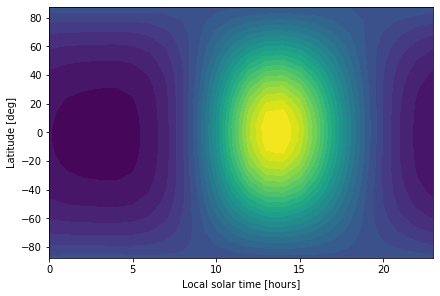

In [38]:
nndecoded_1 = np.reshape(densityNNPred[0,:], (24, 20, 36), order = "f")
#print(nndecoded_1[:,:,18])
fig, ax = plt.subplots(constrained_layout=True)
#norm = mpl.colors.Normalize(vmin=min(np.amin(densityNNPred[0,:]),np.amin(densityDMDcPred[0,:])), vmax=max(np.amax(densityNNPred[0,:]),np.amax(densityDMDcPred[0,:])))
min_val = min(np.amin(densityNNPred[0,:]),np.amin(densityDMDcPred[0,:]))
max_val = max(np.amax(densityNNPred[0,:]),np.amax(densityDMDcPred[0,:]))
#print(range(1, 26)*((max_val-min_val)/25))
l = []
cur = min_val
dif = (max_val-min_val)/25
for i in range(1,26):
    l.append(cur)
    cur += dif
#print(l)
find_buckets = sorted(densityNNPred[0,:].flatten())
#print(len(find_buckets))
a = []
for i in range(0, len(find_buckets), len(find_buckets)//25):
    a.append(find_buckets[i])
#print(a)
inter = 6.75*10**(-13)/25
cur = 1.25*10**(-13)
b =[ ]
for i in range(25):
    cur += inter
    b.append(cur)
#print(b)
    
CS = ax.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, nndecoded_1[:,:,18].T, 25)#vmin=min(np.amin(densityNNPred[0,:]),np.amin(densityDMDcPred[0,:])), vmax=max(np.amax(densityNNPred[0,:]),np.amax(densityDMDcPred[0,:])))#levels = b)#(min_val, max_val, (max_val-min_val)//25))#25, norm = norm)#, extend = "both")
min_val =np.amin(nndecoded_1[:,:,18])
print("min val altitude 18", min_val)
max_val =np.amax(nndecoded_1[:,:,18])
print("max val altitude 18", max_val)

print(nndecoded_1[3][10][18])
ax.set_xlabel('Local solar time [hours]')
ax.set_ylabel('Latitude [deg]')
#norm = fig.colors.Normalize()
#print(min(np.amin(densityNNPred[0,:]),np.amin(densityDMDcPred[0,:])))
#norm = mpl.colors.Normalize(vmin=min(np.amin(densityNNPred[0,:]),np.amin(densityDMDcPred[0,:])), vmax=max(np.amax(densityNNPred[0,:]),np.amax(densityDMDcPred[0,:])))

#cmap = mpl.cm.cool
#norm = mpl.colors.Normalize(vmin=5, vmax=10)

cbar = fig.colorbar(CS, mpl.cm.ScalarMappable(norm=norm))
cbar = fig.colorbar(CS)
cbar.set_clim(vmin = min(np.amin(densityNNPred[0,:]),np.amin(densityDMDcPred[0,:])), vmax = max(np.amax(densityNNPred[0,:]),np.amax(densityDMDcPred[0,:]) ))

cbar.ax.set_ylabel('Density [kg/m^3]')

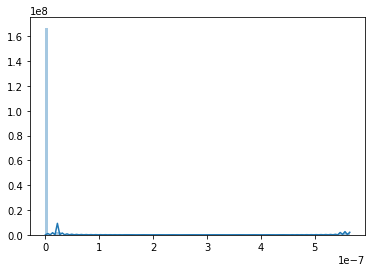

In [39]:
#sns.set(color_codes=True)
# settings for seaborn plot sizes
#sns.set(rc={'figure.figsize':(15,5)})
ax = sns.distplot(densityNNPred[0,:].flatten(),
                  bins=100)

/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (T

<Figure size 432x288 with 0 Axes>

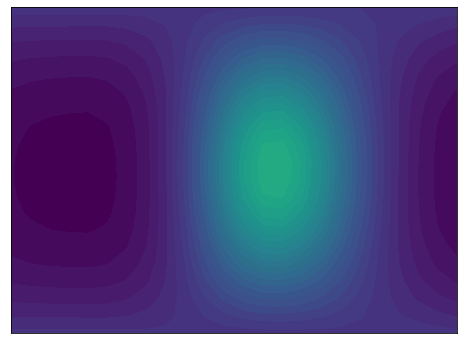

<Figure size 432x288 with 0 Axes>

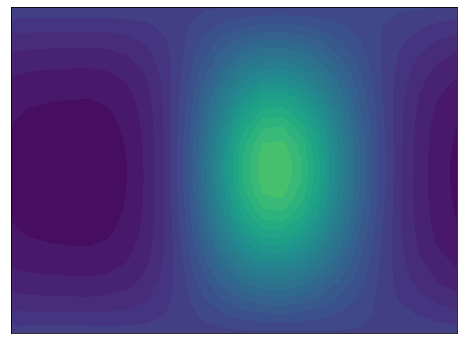

<Figure size 432x288 with 0 Axes>

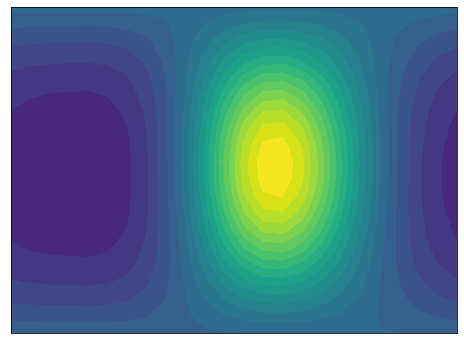

<Figure size 432x288 with 0 Axes>

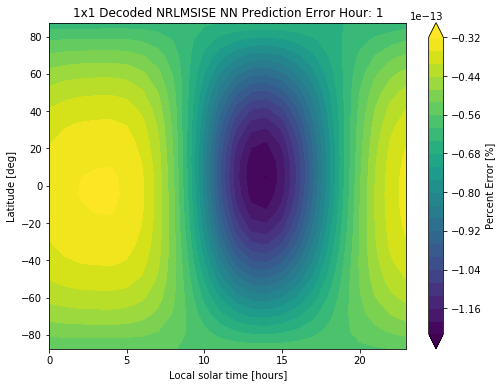

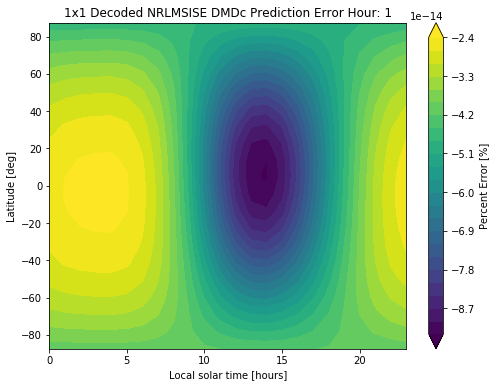

<Figure size 432x288 with 0 Axes>

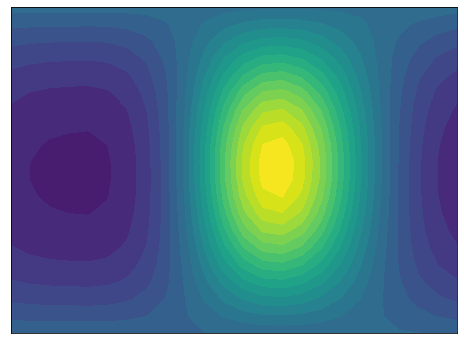

<Figure size 432x288 with 0 Axes>

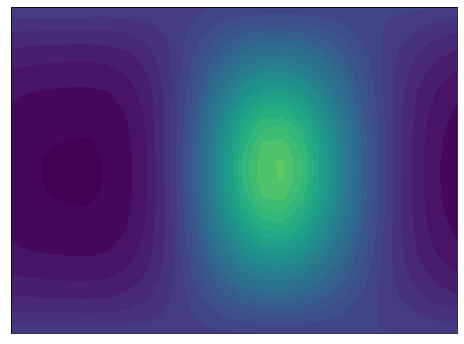

<Figure size 432x288 with 0 Axes>

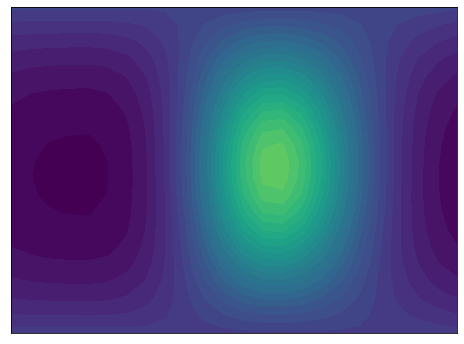

<Figure size 432x288 with 0 Axes>

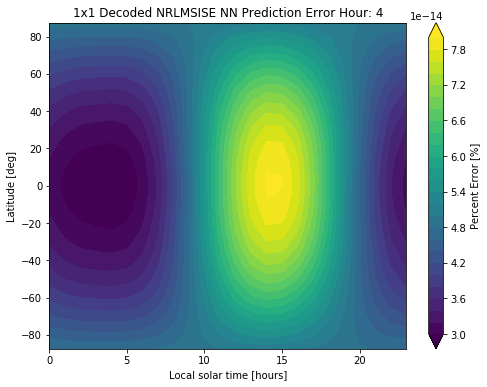

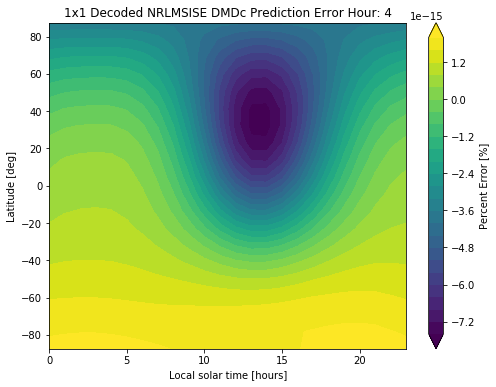

<Figure size 432x288 with 0 Axes>

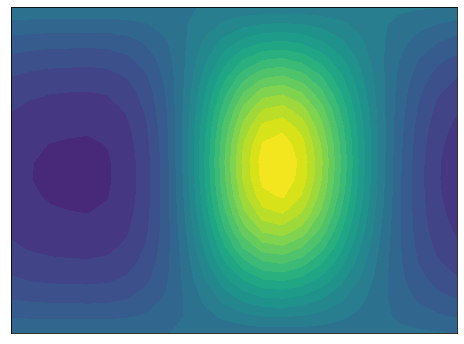

<Figure size 432x288 with 0 Axes>

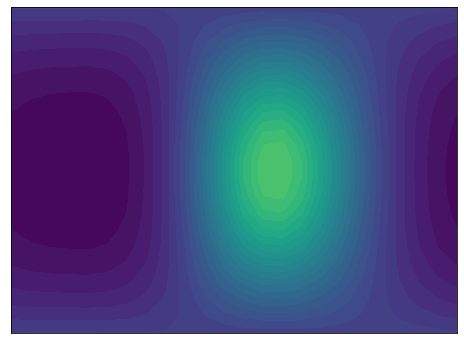

<Figure size 432x288 with 0 Axes>

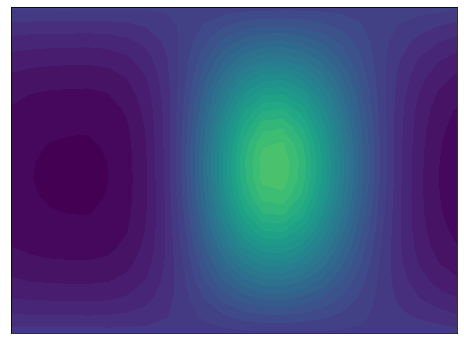

<Figure size 432x288 with 0 Axes>

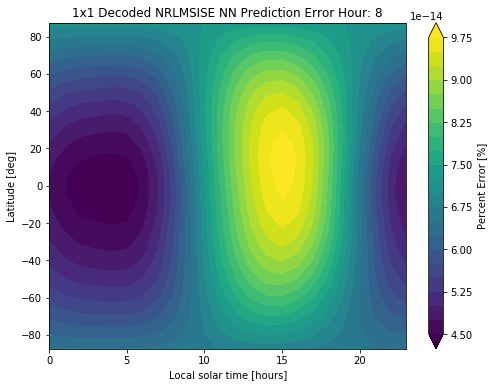

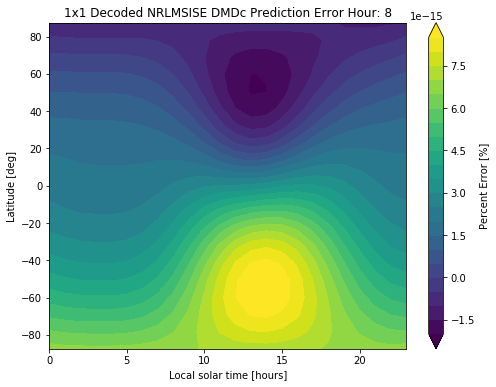

<Figure size 432x288 with 0 Axes>

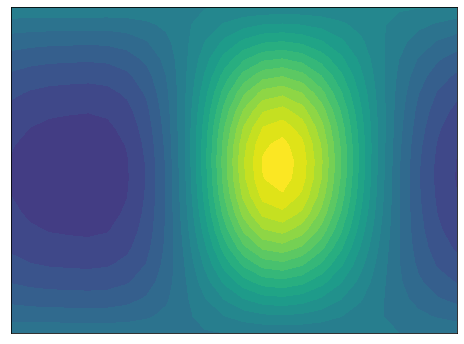

<Figure size 432x288 with 0 Axes>

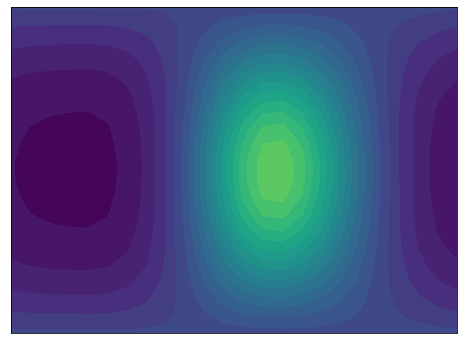

<Figure size 432x288 with 0 Axes>

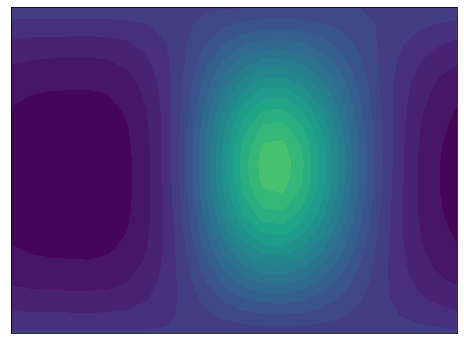

<Figure size 432x288 with 0 Axes>

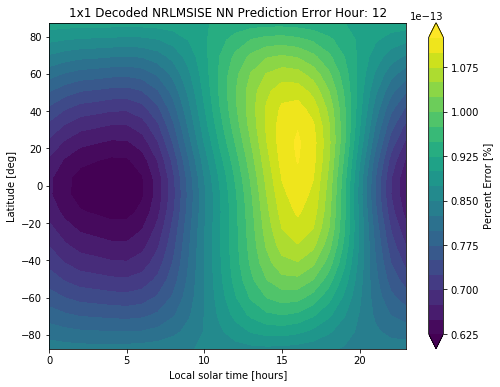

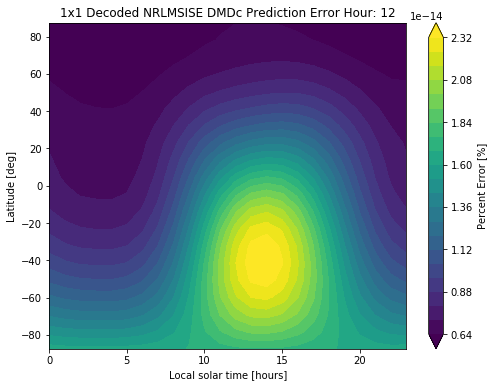

<Figure size 432x288 with 0 Axes>

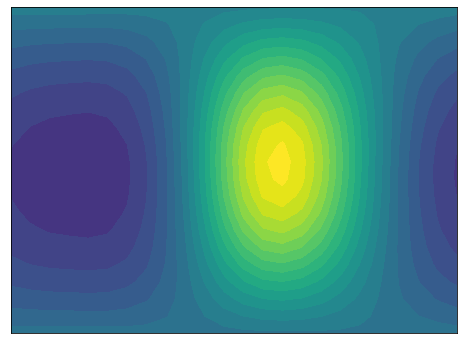

<Figure size 432x288 with 0 Axes>

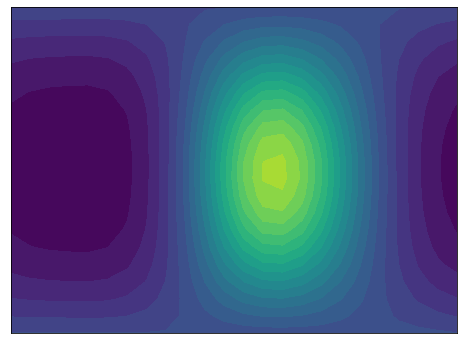

<Figure size 432x288 with 0 Axes>

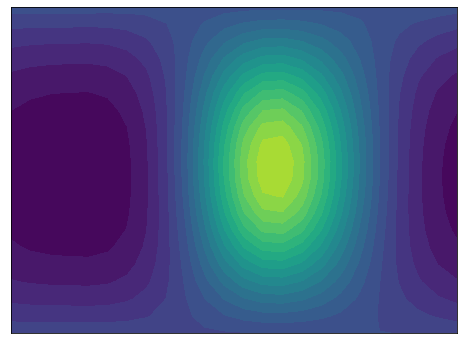

<Figure size 432x288 with 0 Axes>

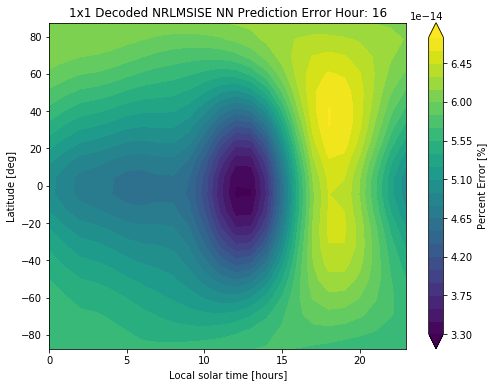

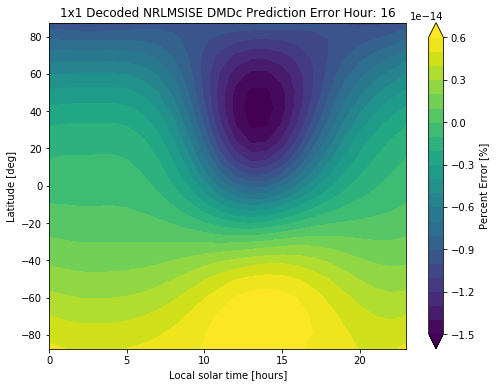

<Figure size 432x288 with 0 Axes>

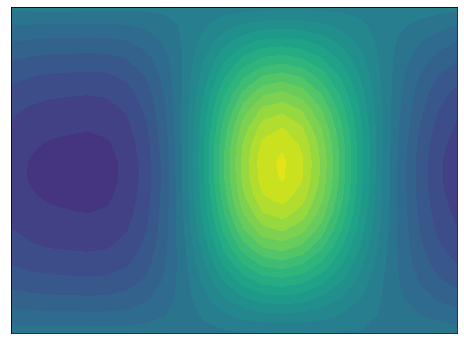

<Figure size 432x288 with 0 Axes>

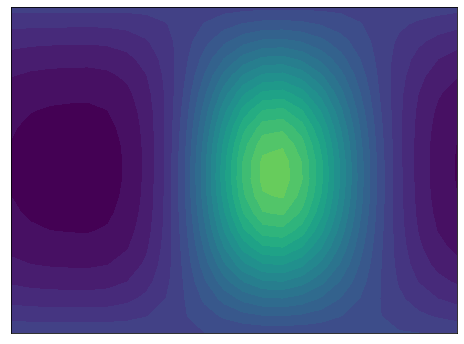

<Figure size 432x288 with 0 Axes>

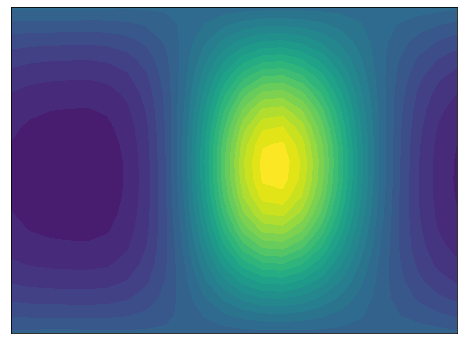

<Figure size 432x288 with 0 Axes>

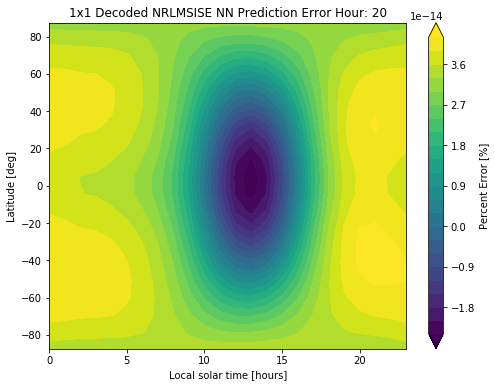

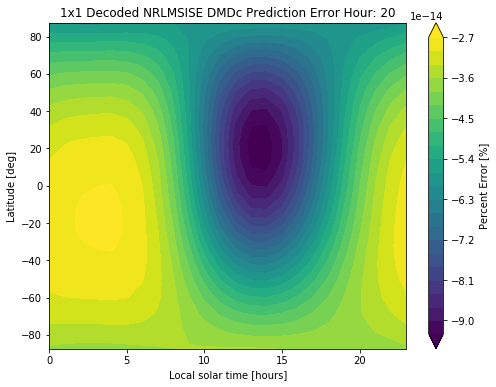

<Figure size 432x288 with 0 Axes>

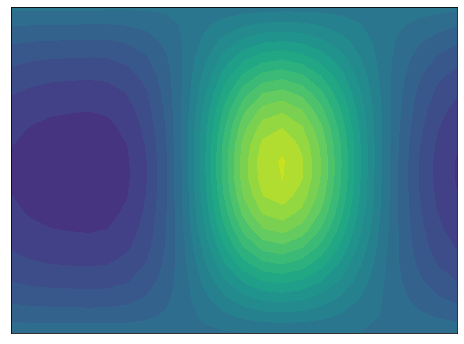

<Figure size 432x288 with 0 Axes>

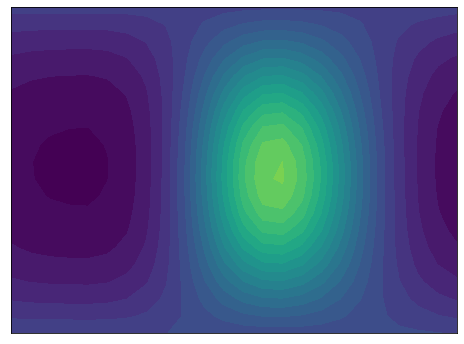

<Figure size 432x288 with 0 Axes>

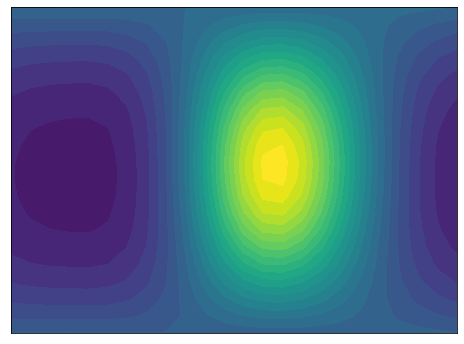

<Figure size 432x288 with 0 Axes>

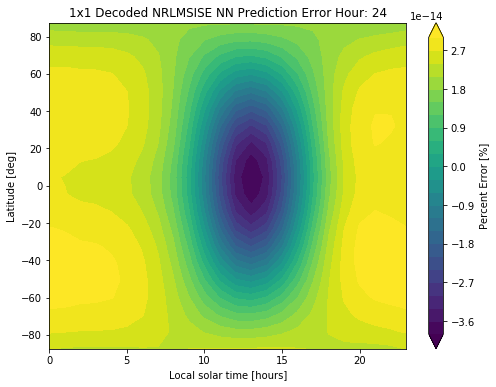

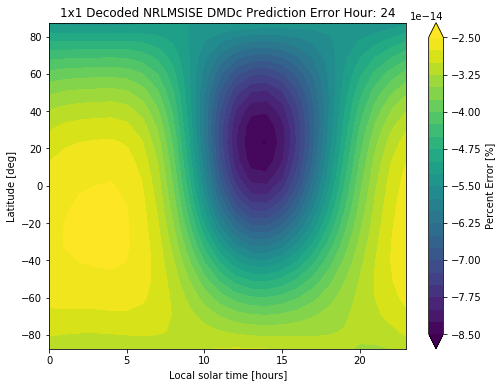

In [51]:
hours = [0,3,7,11,15,19,23]
for h in hours:
    nndecoded_1 = np.reshape(densityNNPred[h,:], (24, 20, 36), order = "f")
    DMDcdecoded_1 = np.reshape(densityDMDcPred[h,:], (24, 20, 36), order = "f")
    actual_1 = np.reshape(actualPred[h,:], (24, 20, 36), order = "f")
    #actual_1 = np.reshape(dens_data.T[:,split_15-pred_number+h],(24, 20, 36), order = "f")
    
    nn_error = np.reshape(densityNNPred_Error[h,:], (24, 20, 36), order = "f") #np.divide((nndecoded_1-actualPred_1),actualPred_1)
    dmdc_error = np.reshape(densityDMDcPred_Error[h,:], (24, 20, 36), order = "f") # np.divide((DMDcdecoded_1-actualPred_1),actualPred_1)
    #print(densityNNPred[:,:,18])
    
    plt.figure()
    
    fig, ax1 = plt.subplots( figsize=(8,6))
    #ax1.set_title("1x1 Decoded NRLMSISE NN Prediction Hour: "+str(h+1))
    CS1 = ax1.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, nndecoded_1[:,:,18].T, levels = 25,vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    #CS2 = ax2.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, 10**DMDcdecoded_1[:,:,18].T, 25, extend = "both")
    #ax1.set_xlabel('Local solar time [hours]')
    #ax1.set_ylabel('Latitude [deg]')
    #norm = mpl.colors.Normalize(vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    #cbar = fig.colorbar(CS1, ax = ax1, norm = norm)
    #cbar.ax.set_ylabel('Density [kg/m^3]')
    #CS1.set_clim(vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)
    plt.savefig("JB_ROM_NN_Prediction_Hour"+str(h+1)+".png")
    
    plt.figure()
    #fig, ax = plt.subplots(constrained_layout=True)
    fig, ax2 = plt.subplots( figsize=(8,6))
    #ax2.set_title("1x1 Decoded NRLMSISE DMDc Prediction Hour: "+str(h+1))
    CS2 = ax2.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, DMDcdecoded_1[:,:,18].T, levels = 25,vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    '''
    ax2.set_xlabel('Local solar time [hours]')
    ax2.set_ylabel('Latitude [deg]')
    cbar = fig.colorbar(CS2, ax = ax2, norm = norm)
    cbar.ax.set_ylabel('Density [kg/m^3]')
    CS2.set_clim(vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    #'''
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)
    plt.savefig("JB_ROM_DMDc_Prediction_Hour"+str(h+1)+".png")
    
    
    plt.figure()
    fig, ax3 = plt.subplots(figsize=(8,6))
    #ax3.set_title("1x1 Decoded NRLMSISE DMDc Prediction Hour: "+str(h+1))
    CS3 = ax3.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, actual_1[:,:,18].T, levels = 25,vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    '''
    ax3.set_xlabel('Local solar time [hours]')
    ax3.set_ylabel('Latitude [deg]')
    cbar = fig.colorbar(CS3, ax = ax3)
    cbar.ax.set_ylabel('Density [kg/m^3]')
    #'''
    ax3.axes.xaxis.set_visible(False)
    ax3.axes.yaxis.set_visible(False)
    plt.savefig("JB_ROM_Actual_Hour"+str(h+1)+".png")
    
    plt.figure()
    fig, ax1 = plt.subplots(figsize=(8,6))
    ax1.set_title("1x1 Decoded NRLMSISE NN Prediction Error Hour: "+str(h+1))
    CS = ax1.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, nn_error[:,:,18].T, 25, extend = "both")
    ax1.set_xlabel('Local solar time [hours]')
    ax1.set_ylabel('Latitude [deg]')
    cbar = fig.colorbar(CS, ax = ax1)
    cbar.ax.set_ylabel('Percent Error [%]')
    #plt.savefig("1x1_Decoded_NRLMSISE_NN_Prediction_Error_Hour"+str(h+1)+".png")
    
    fig, ax2 = plt.subplots(figsize=(8,6))
    ax2.set_title("1x1 Decoded NRLMSISE DMDc Prediction Error Hour: "+str(h+1))
    CS = ax2.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, dmdc_error[:,:,18].T, 25, extend = "both")
    ax2.set_xlabel('Local solar time [hours]')
    ax2.set_ylabel('Latitude [deg]')
    cbar = fig.colorbar(CS, ax = ax2)
    cbar.ax.set_ylabel('Percent Error [%]')
    #plt.savefig("1x1_Decoded_NRLMSISE_DMDc_Prediction_Error_Hour"+str(h+1)+".png")
    